# Twitter Sentiment Analysis

## Import Libraries

In [1]:
import numpy as np
import pandas as pd

#### Helpers

In [2]:
from utils import *
from preprocessing import *
from plots import *

#### Data Preprocessing

In [3]:
from nltk.probability import FreqDist
from nltk.corpus import stopwords

#### Feature Extraction

In [4]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction import text
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

from sklearn.model_selection import train_test_split

#### Cross validation

In [5]:
from sklearn.cross_validation import cross_val_score
from sklearn.cross_validation import KFold as cross_validation_KFold

from sklearn.model_selection import learning_curve

/home/sarigian/miniconda3/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


#### Machine Learning

In [6]:
from sklearn.naive_bayes import MultinomialNB, GaussianNB, BernoulliNB
from sklearn import svm

#### Options

In [7]:
pd.options.mode.chained_assignment = None

## Load Data

In [8]:
data_path = '../data/'
pos_tweets_file = 'train_pos_full.txt'
neg_tweets_file = 'train_neg_full.txt'
test_tweets_file = 'test_data.txt'

### Train Data

In [9]:
pos_tweets = pd.read_table(data_path+pos_tweets_file, names=['tweet','sentiment'])
pos_tweets['sentiment'] = 'pos'
neg_tweets = pd.read_table(data_path+neg_tweets_file ,names=['tweet','sentiment'])
neg_tweets['sentiment'] = 'neg'

/home/sarigian/.local/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [10]:
pos_tweets.head()

,tweet,sentiment
0,<user> i dunno justin read my mention or not ....,pos
1,"because your logic is so dumb , i won't even c...",pos
2,<user> just put casper in a box ! looved the...,pos
3,<user> <user> thanks sir > > don't trip lil ma...,pos
4,visiting my brother tmr is the bestest birthda...,pos


In [11]:
neg_tweets.head()

,tweet,sentiment
0,vinco tresorpack 6 ( difficulty 10 of 10 objec...,neg
1,glad i dot have taks tomorrow ! ! #thankful #s...,neg
2,1-3 vs celtics in the regular season = were fu...,neg
3,<user> i could actually kill that girl i'm so ...,neg
4,<user> <user> <user> i find that very hard to ...,neg


In [12]:
print('positive tweets shape: ',pos_tweets.shape)
print('negative tweets shape: ',neg_tweets.shape)

positive tweets shape:  (1218655, 2)
negative tweets shape:  (1239642, 2)


In [13]:
tweets = pd.concat([pos_tweets, neg_tweets], axis=0)
tweets.shape

(2458297, 2)

In [14]:
tweets.head()

,tweet,sentiment
0,<user> i dunno justin read my mention or not ....,pos
1,"because your logic is so dumb , i won't even c...",pos
2,<user> just put casper in a box ! looved the...,pos
3,<user> <user> thanks sir > > don't trip lil ma...,pos
4,visiting my brother tmr is the bestest birthda...,pos


In [15]:
tweets.tail()

,tweet,sentiment
1239637,im so sorry ! <user> & to <user> & <user> u gu...,neg
1239638,i can't find food coloring anywhere,neg
1239639,<user> same here ! ! but tort ! ! wonder why y...,neg
1239640,keyless entry remote fob clicker for 2005 buic...,neg
1239641,<user> yeap . doctor don't know what's wrong w...,neg


### Test Data

In [16]:
test_tweets = pd.read_table(data_path+test_tweets_file, names=['tweet','sentiment'])
test_tweets['tweet'] = test_tweets.apply(lambda tweet: remove_tweet_id(tweet['tweet']), axis=1)
test_tweets.head()

,tweet,sentiment
0,sea doo pro sea scooter ( sports with the port...,NaN
1,<user> shucks well i work all week so now i ca...,NaN
2,i cant stay away from bug thats my baby,NaN
3,<user> no ma'am ! ! ! lol im perfectly fine an...,NaN
4,"whenever i fall asleep watching the tv , i alw...",NaN


## Tweets Preprocessing

### Remove Duplicate Tweets

Duplicates are removed to avoid putting extra weight on any particular tweet.

In [17]:
print('number of tweets before duplicates removal:\t', tweets.shape[0])
tweets.drop_duplicates(subset='tweet', inplace=True)
print('number of tweets after duplicates removal:\t', tweets.shape[0])

number of tweets before duplicates removal:	 2458297
number of tweets after duplicates removal:	 2230333


### Fix repeated letters

We use preprocessing so that any letter occurring more than two times in a row is replaced with two occurrences.
As an example, the words haaaaaaaaappy and haaaaappy should be converted to haappy

In [18]:
tweets['tweet'] = tweets.apply(lambda tweet: filter_repeated_chars_on_tweet(tweet['tweet']), axis=1)

### Convert all tweets to lowercase

In [19]:
# done by default
# tweets['tweet'] = convert_to_lowercase(tweets['tweet'])

### Filter Punctuation

In [20]:
# done by default from vectorizer?

### filter Stopwords

In [21]:
stoplist = stopwords.words('english')
fdist = FreqDist(stoplist)
top = fdist.most_common(1000)
top = [x[0] for x in top] 

stop_words = set(top)
my_stop_words = text.ENGLISH_STOP_WORDS.union(stop_words)

### Part of speech tagging

In [22]:
# tweets['tagged'] = tweets.apply(lambda tweet: pos_tag(tweet['tweet']), axis=1)

### Lemmatization/Stemming

### Tweets final representation

In [23]:
tweets

,tweet,sentiment
0,<user> i dunno justin read my mention or not ....,pos
1,"because your logic is so dumb , i won't even c...",pos
2,<user> just put casper in a box ! looved the...,pos
3,<user> <user> thanks sir > > don't trip lil ma...,pos
4,visiting my brother tmr is the bestest birthda...,pos
5,<user> yay ! ! #lifecompleted . tweet / facebo...,pos
6,<user> #1dnextalbumtitle : feel for you / roll...,pos
7,workin hard or hardly workin rt <user> at hard...,pos
8,<user> i saw . i'll be replying in a bit .,pos
9,this is were i belong,pos


## Feature Extraction

In [24]:
X_train, X_test, y_train, y_test = train_test_split(tweets['tweet'], tweets['sentiment'], test_size=0.10, random_state=4)

### bag of words

#### occurencies

In [25]:
# #initialize bag of words
# count_vectorizer = CountVectorizer(min_df=1)

# count_train_vectors = count_vectorizer.fit_transform(X_train)
# count_test_vectors = count_vectorizer.transform(X_test)
# #shape: (number_of_tweets, all_words)

#### frequencies TF-IDF

In [26]:
#initialize bag of words (tf-idf)
#ngram_range=(1, 2)
tfidf_vectorizer = TfidfVectorizer(min_df=5, max_df = 0.8, sublinear_tf=True, use_idf=True, stop_words=my_stop_words)

tfidf_train_vectors = tfidf_vectorizer.fit_transform(X_train)
tfidf_test_vectors = tfidf_vectorizer.transform(X_test)
#shape: (number_of_tweets, all_words)

## Feature Expansion

### polynomial expansion

### standardization

## Classification

### Naive Bayes

In [27]:
# clf = MultinomialNB()
# clf.fit(count_train_vectors, y_train)
# prediction_bayes = clf.predict(count_test_vectors)
# prediction_bayes.shape

In [28]:
# print(classification_report(y_test, prediction_bayes))
# print('score: ',accuracy_score(y_test,prediction_bayes))

In [29]:
clf = MultinomialNB()
clf.fit(tfidf_train_vectors, y_train)
prediction_bayes = clf.predict(tfidf_test_vectors)
prediction_bayes.shape

(223034,)

In [30]:
print(classification_report(y_test, prediction_bayes))
print('score: ',accuracy_score(y_test,prediction_bayes))

             precision    recall  f1-score   support

        neg       0.81      0.68      0.74    113501
        pos       0.71      0.84      0.77    109533

avg / total       0.76      0.76      0.75    223034

score:  0.755436390864


#### Get top k most important features

In [31]:
print(topk_most_important_features(tfidf_vectorizer, clf, k=10))

['user', 'love', 'good', 'follow', 'lol', 'thanks', 'rt', 'know', 'url', 'like']


In [32]:
show_most_informative_features(tfidf_vectorizer, clf, n=1000)

	-14.6422	0010           		-3.2602	user           
	-14.6422	0012           		-4.8331	love           
	-14.6422	0015           		-4.9225	good           
	-14.6422	0016           		-5.0416	follow         
	-14.6422	0017           		-5.0481	lol            
	-14.6422	001us          		-5.0538	thanks         
	-14.6422	0021           		-5.1344	rt             
	-14.6422	0024           		-5.2063	know           
	-14.6422	0026           		-5.2081	url            
	-14.6422	0028           		-5.2316	like           
	-14.6422	0030           		-5.2848	day            
	-14.6422	0032           		-5.3430	haha           
	-14.6422	003us          		-5.4620	xx             
	-14.6422	004us          		-5.4691	thank          
	-14.6422	0052           		-5.6332	happy          
	-14.6422	0078           		-5.6603	time           
	-14.6422	0079           		-5.6633	today          
	-14.6422	0085           		-5.6687	got            
	-14.6422	00h            		-5.7019	think          
	-14.6422	00m            		-5.7

## K fold Cross validation

In [33]:
cv = cross_validation_KFold(tweets.shape[0], shuffle = True, n_folds=2, random_state=4)
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 2),min_df=5, max_df = 0.8, sublinear_tf=True, use_idf=True, stop_words=my_stop_words)
tfidf_train_vectors = tfidf_vectorizer.fit_transform(tweets['tweet'])
clf = MultinomialNB()
avg_test_accuracy = np.mean(cross_val_score(clf, tfidf_train_vectors, tweets['sentiment'], cv=cv, scoring='accuracy'))
print(avg_test_accuracy)

0.779766070884


### SVM

In [34]:
# classifier_linear = svm.SVC(kernel='linear')
# classifier_linear.fit(tfidf_train_vectors, y_train)
# prediction_linear = classifier_linear.predict(tfidf_test_vectors)
# prediction_linear.shape

In [35]:
# print(classification_report(y_test, prediction_linear))
# print(accuracy_score(y_test,prediction_bayes))

## Learning curves

### Naive Bayes

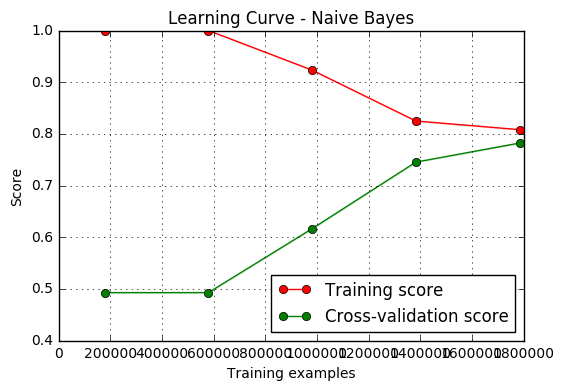

In [36]:
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 2),min_df=5, max_df = 0.8, sublinear_tf=True, use_idf=True, stop_words=my_stop_words)
tfidf_train_vectors = tfidf_vectorizer.fit_transform(tweets['tweet'])
clf = MultinomialNB()
cv = cross_validation_KFold(tweets.shape[0],shuffle = True, n_folds=5, random_state=4)
plot_learning_curve(clf, 'Learning Curve - Naive Bayes', tfidf_train_vectors, tweets['sentiment'], cv=cv)
plt.show()

## Write results to file

In [37]:
pred_file = 'pred_submission.csv'
create_csv_submission(prediction_bayes, data_path+pred_file)

## Test Code

In [38]:
from nltk.corpus import brown
len(brown.words())

1161192